In [1]:
import pandas as pd
import numpy as np

import sys

import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

In [2]:
from pathlib import Path

project_root = Path().resolve().parent
sys.path.append(str(project_root)) 

In [3]:
from src import config, dataset, model, train, utils

# Предпросмотр данных

In [4]:
df = pd.read_csv(config.TRAIN_DATA_PATH)
df.head()

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


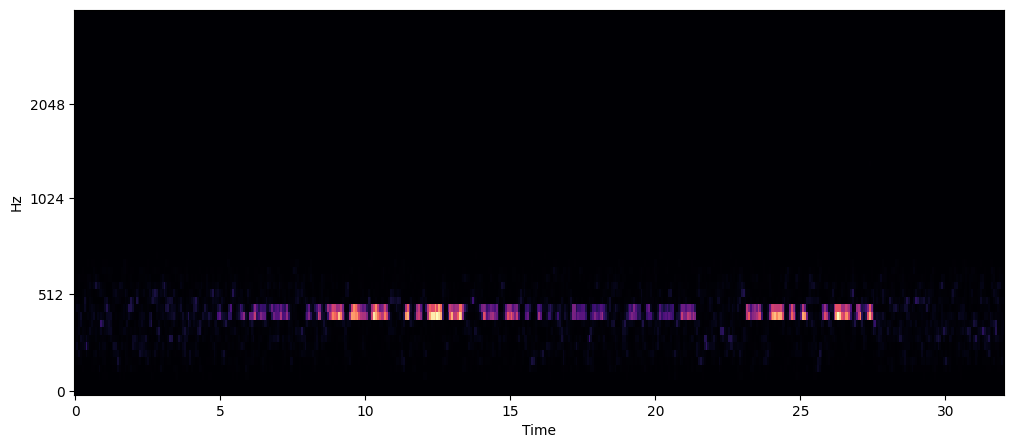

In [5]:
y, sr = librosa.load(project_root / "morse_dataset/morse_dataset/5.opus", sr=config.SAMPLE_RATE)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, 
                                          n_mels=60, 
                                          n_fft=512, 
                                          hop_length=128, 
                                          power=3)

plt.figure(figsize=(12, 5))
librosa.display.specshow(mel_spec, sr=sr, x_axis="time", y_axis="mel", cmap="magma")
plt.show()

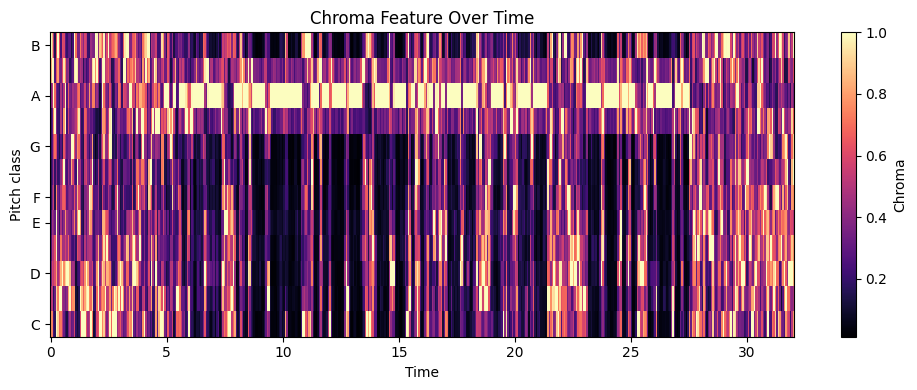

In [6]:
y, sr = librosa.load(project_root / "morse_dataset/morse_dataset/5.opus", sr=config.SAMPLE_RATE)
chroma = librosa.feature.chroma_stft(y=y, sr=sr, 
                                     n_fft=512, 
                                     hop_length=128)

plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sr)
plt.colorbar(label='Chroma')
plt.title('Chroma Feature Over Time')
plt.tight_layout()
plt.show()

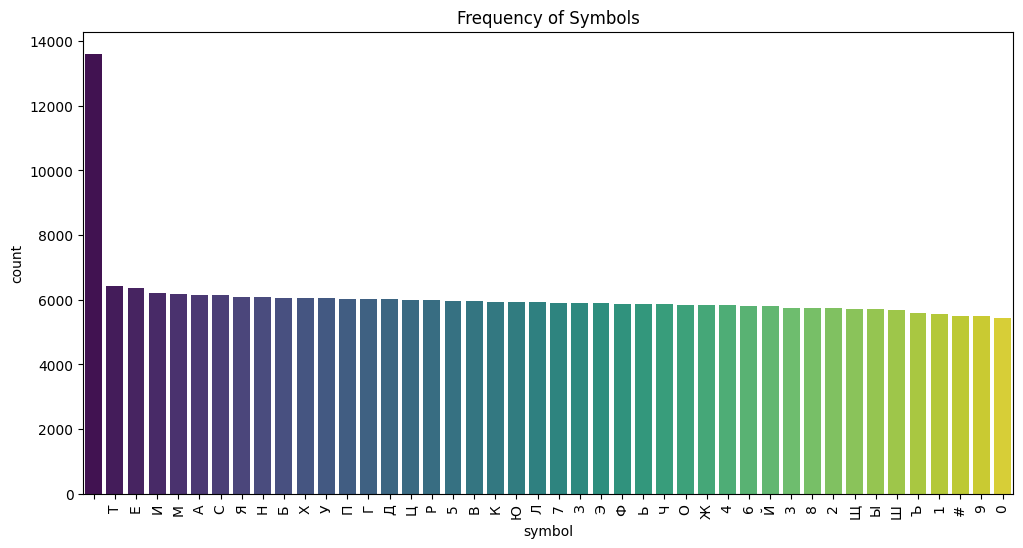

In [7]:
symbols = Counter()
for message in df['message']:
    symbols.update(Counter(message))

symbol_df = pd.DataFrame(symbols.items(), columns=['symbol', 'count'])
symbol_df = symbol_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=symbol_df, x='symbol', y='count', palette="viridis")
plt.xticks(rotation=90) 
plt.title('Frequency of Symbols')
plt.show()

# Выгрузка фичей из аудио

In [8]:
def extract_features_from_morse(path: str,
                                limited_time: bool
                                ) -> tuple[np.ndarray, int]:
    # Загрузка сигнала
    y, sr = librosa.load(path, sr=config.SAMPLE_RATE, 
                         duration=config.TARGET_DURATION_SEC if limited_time else None)
    
    # Получение mel-спектрограммы
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, 
                                              n_mels=config.N_MELS, 
                                              n_fft=config.N_FFT, 
                                              hop_length=config.HOP_LENGTH, 
                                              power=config.POWER)
    mel_spec = librosa.power_to_db(mel_spec)

    # Получение chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, 
                                         n_fft=config.N_FFT, 
                                         hop_length=config.HOP_LENGTH)
    
    # Определение промежутков тишины
    sorted_indices = np.argsort(chroma.mean(axis=1))
    top7_indices = sorted_indices[:-1][-8:] # Без первого, так как на этой частоте содержится сам сигнал
    top7_energies = chroma[top7_indices, :]
    top7_energies = top7_energies / np.max(top7_energies, axis=1, keepdims=True) # нормализация по каждой частоте
    silence_detection = top7_energies.mean(axis=0) # Усреднение значений для получения наиболее точной картины
    
    # Выбор топ-n частот с наибольшей энергией
    topn_indices = np.argsort(mel_spec.mean(axis=1))[-3:]
    topn_energies = mel_spec[topn_indices, :] # Получение значений на этих частотах
    topn_energies = topn_energies / np.max(topn_energies, axis=1, keepdims=True)  # нормализация по каждой частоте
    
    # Выбор максимальной энергии для каждого временного шага
    max_energy_per_frame = np.max(mel_spec, axis=0)
    max_energy_per_frame /= np.max(max_energy_per_frame)  # нормализация

    # Объединение данных для обучения
    features = np.vstack([
        topn_energies,
        max_energy_per_frame[None, :],
        silence_detection[None, :]
    ]).T
    num_features = features.shape[1]

    return features, num_features

Просмотр полученных признаков из Морзе

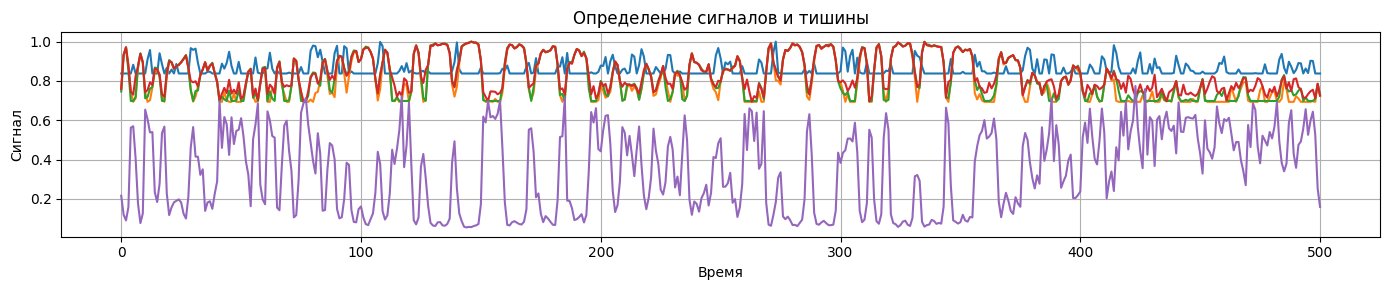

In [9]:
features, num_feats = extract_features_from_morse(project_root / "morse_dataset/morse_dataset/1234.opus", True)
plt.figure(figsize=(14, 3))
plt.plot(features)
plt.title("Определение сигналов и тишины")
plt.xlabel("Время")
plt.ylabel("Сигнал")
plt.grid(True)
plt.tight_layout()
plt.show()

# Подготовка данных для обучения

In [12]:
train_df = pd.read_csv(config.TRAIN_DATA_PATH)
utils.preprocess_data(train_df, config.PREP_DATA_PATH, extract_features_from_morse)

100%|██████████| 30000/30000 [23:46<00:00, 21.03it/s]


# Формирование датасета

In [10]:
prep_df = pd.read_csv(config.PREP_DATA_PATH)
dataloaders = dataset.get_dataloaders(df=prep_df,
                                      val_size=1000,
                                      random_seed=config.SEED,
                                      batch_size=config.BATCH_SIZE)

# Разработка нейросетевой модели

In [10]:
import torch
from torch.nn import CTCLoss

In [ ]:
MorseModel = model.MorseNet(
    conv_input_channels=num_feats,
    conv_output_channels=config.CNN_OUT_CHANNELS,
    rnn_hidden=config.RNN_HIDDEN_SIZE,
    rnn_layers=config.RNN_LAYERS,
    rnn_type=config.RNN_TYPE,
    rnn_dropout=config.RNN_DROPOUT,
    linear_dropout=config.LINEAR_DROPOUT,
    num_classes=config.NUM_CLASSES
).to(config.DEVICE)

criterion = CTCLoss(blank=config.NUM_CLASSES, 
                    reduction="mean", 
                    zero_infinity=True)

optimizer = torch.optim.Adam(MorseModel.parameters(), 
                             lr=config.LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min', 
                                                       factor=0.5, 
                                                       patience=config.EARLY_STOPPING_PATIENCE)

In [13]:
train.train_model(MorseModel, 
                  criterion, 
                  optimizer, 
                  scheduler, 
                  dataloaders, 
                  config.DEVICE, 
                  num_epochs=5)


Epoch 1/5
----------------------------------------


Train: 100%|██████████| 454/454 [04:36<00:00,  1.64it/s]


Train | Loss: 0.5185 | Avg Levenshtein: 3.7506


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]


Validation | Loss: 0.1377 | Avg Levenshtein: 1.0560

Epoch 2/5
----------------------------------------


Train: 100%|██████████| 454/454 [04:44<00:00,  1.60it/s]


Train | Loss: 0.0867 | Avg Levenshtein: 0.7355


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]


Validation | Loss: 0.0577 | Avg Levenshtein: 0.5370

Epoch 3/5
----------------------------------------


Train: 100%|██████████| 454/454 [05:00<00:00,  1.51it/s]


Train | Loss: 0.0558 | Avg Levenshtein: 0.5209


Validation: 100%|██████████| 16/16 [00:03<00:00,  4.03it/s]


Validation | Loss: 0.0500 | Avg Levenshtein: 0.4820

Epoch 4/5
----------------------------------------


Train: 100%|██████████| 454/454 [04:39<00:00,  1.62it/s]


Train | Loss: 0.0469 | Avg Levenshtein: 0.4593


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]


Validation | Loss: 0.0454 | Avg Levenshtein: 0.4550

Epoch 5/5
----------------------------------------


Train: 100%|██████████| 454/454 [04:45<00:00,  1.59it/s]


Train | Loss: 0.0429 | Avg Levenshtein: 0.4257


Validation: 100%|██████████| 16/16 [00:04<00:00,  3.79it/s]

Validation | Loss: 0.0393 | Avg Levenshtein: 0.3970


Сохранение лучшей модели

In [16]:
torch.save(MorseModel.state_dict(), project_root / 'models/model_5ep_new.pth')

# Проверка работоспособности модели

In [11]:
MorseModel = model.MorseNet(
    conv_input_channels=num_feats,
    conv_output_channels=config.CNN_OUT_CHANNELS,
    rnn_hidden=config.RNN_HIDDEN_SIZE,
    rnn_layers=config.RNN_LAYERS,
    rnn_type=config.RNN_TYPE,
    rnn_dropout=config.RNN_DROPOUT,
    linear_dropout=config.LINEAR_DROPOUT,
    num_classes=config.NUM_CLASSES
).to(config.DEVICE)
MorseModel.load_state_dict(torch.load(project_root / "models/model_26ep_new_v3.pth", weights_only=True))

<All keys matched successfully>

In [12]:
print(f'Total parameters: {sum(p.numel() for p in MorseModel.parameters())}')

Total parameters: 1919302


In [15]:
df_test = utils.process_dataframe(df.sample(200), MorseModel, extract_features_from_morse)
df_test

100%|██████████| 200/200 [00:15<00:00, 12.50it/s]


,id,message,predicted,levenshtein
8586,8587.opus,ЯФ9ЗАЦТ9,ЯФ9ЗАЦТ9,0
9045,9046.opus,0ЧУЯЦМ1ЕКЮ,0ЧУЯЦМ1ЕКЮ,0
10968,10969.opus,В7ТС0#ОА,В7ТС0#ОА,0
16344,16345.opus,9ЧБДБ9Ш,9ЧБДБ9Ш,0
24284,24285.opus,71ЦЯСДЕ,71ЦЯСДЕ,0
...,...,...,...,...
2191,2192.opus,НЯ8940ЭХ,НЯ8940ЭХ,0
14340,14341.opus,Ы#ЩЪПШ Г,Ы#ЩЪПШ Г,0
1508,1509.opus,Ч МБИЕУЭЯДК,Ч МБИЕУЭЯДК,0
22556,22557.opus,Р1УМЮ4ЬТ,Р1УМЮ4ЬТ,0


In [16]:
df_test['levenshtein'].mean()

0.125

Подготовка submission файла

In [17]:
sub_df = pd.read_csv(config.SUB_DATA_PATH)

sub_df = utils.get_submission(sub_df, MorseModel, extract_features_from_morse)

sub_df.to_csv(config.SUBMISSION_PATH, index=False)
print("submission file created")

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [06:26<00:00, 12.95it/s]

submission file created
